# **STOCK MARKET PRICE PREDICTOR**

Objective of this project is to analyze the effect of adding some generality in building a stock price predictor for a selected stock by adding data of other stocks in model training while using a correlation coefficient to adjust their impact in learning the model weights

In [122]:
import pandas as pd
import numpy as np
import os   
import math
import json

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

import settings

from scipy.special import softmax

## SELECTION OF STOCKS
12 Stocks are selected, 3 stocks from each of the sectors in banking, healthcare, information technology and Energy sector to keep a balanced effect of correlation from various categories of companies. 1 stock from these 12 is selected as the target stock for which price predictions will be focused on. 


In [123]:
SELECTED_STOCKS = [
    'SBIN', 'HDFCBANK', 'AXISBANK', 
    'SUNPHARMA', 'DRREDDY', 'CIPLA',
    'INFY', 'WIPRO', 'TCS', 
    'BPCL', 'COALINDIA', 'POWERGRID'
]
TARGET_STOCK = 'SBIN'

In [124]:
def load_dataset():
    """
    Loads all files present in NiftyData Folder. All the stock data is added as a dataframe element to the equity_data list.
    Sector mapping is loaded from file stock_metadata.csv .

    Returns:
        equity_data : dict <stock_name : pd.DataFrame > Fetched data of stocks
    """
    dir_contents = os.listdir(settings.NIFTY_DATA_DIR)
    files = [f for f in dir_contents if os.path.isfile(settings.NIFTY_DATA_DIR + '/' + f) and f.endswith(".csv")]
    equity_data = {}

    column_names = {
        'Date': "DATE",
        "Prev Close": "PREV_CLOSE",
        "Open": "OPEN",
        "High": "HIGH",
        "Low": "LOW",
        "Close": "CLOSE",
        "VWAP": "VWAP",
        "Volume": "VOLUME",
        "Turnover": "TURNOVER"
    }
    for file in files:
        if file[:-4] not in SELECTED_STOCKS: # Only load the selected stocks
            continue

        stock_data = pd.read_csv(os.path.join(settings.NIFTY_DATA_DIR, file))
        stock_data = stock_data.drop(['Symbol', 'Series', 'Last', 'Trades', 'Deliverable Volume', '%Deliverble'], axis=1)
        stock_data.rename(columns = column_names, inplace = True)
        equity_data[file[:-4]] = stock_data
    
    return equity_data

In [125]:
EQUITY_DATA = load_dataset()
print(f"""
Number of Stocks : {len(EQUITY_DATA.keys())}
List of Stocks : {EQUITY_DATA.keys()}
Features : {list(EQUITY_DATA[TARGET_STOCK].columns)}
""")


Number of Stocks : 12
List of Stocks : dict_keys(['SUNPHARMA', 'TCS', 'WIPRO', 'SBIN', 'DRREDDY', 'INFY', 'POWERGRID', 'CIPLA', 'COALINDIA', 'HDFCBANK', 'BPCL', 'AXISBANK'])
Features : ['DATE', 'PREV_CLOSE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VWAP', 'VOLUME', 'TURNOVER']



In [132]:
EQUITY_DATA['SBIN'].head()

,DATE,PREV_CLOSE,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,TURNOVER
0,2000-01-03,225.60,236.00,243.65,234.25,243.65,240.83,2373228,5.715338e+13
1,2000-01-04,243.65,243.65,262.00,238.85,259.10,251.46,4495741,1.130506e+14
2,2000-01-05,259.10,249.00,264.70,245.00,248.45,252.35,3434058,8.666008e+13
3,2000-01-06,248.45,252.00,268.00,252.00,261.00,262.18,6658801,1.745817e+14
4,2000-01-07,261.00,261.50,279.90,255.00,273.30,269.02,7873985,2.118287e+14


## FEATURE GENERATION
Instead of using standard features of open and close values of stocks, we are going to use custom built features which are itself predictions from some basic price prediction models. 2 methods of feature generation that we have used are :
- Linear regression with variable degrees
- Curve similarity with varying curve length

### LINEAR REGRESSION FEATURES

In [127]:
CUSTOM_FEATURES = dict()    # Dictionary [pd.DataFrame]
TIME_SERIES_INTERVAL = 60

In [128]:
def generate_linear_regression_features(time_series_batch:pd.DataFrame, list_of_powers = [2, 3, 4, 5]):
    """
    Generates features based on predictions from various linear regression models with the given degrees of powers

    Returns :
        pd.DataFrame : [New Features, Actual Value]
    """
    new_features = pd.DataFrame()
    list_of_predictions = list()
    for power in range(max(list_of_powers)+1):
        new_features[f'POWER_{power}'] = time_series_batch["PREV_CLOSE"].apply(lambda x: x**power)
        if power in list_of_powers:
            linear_regression_model = LinearRegression()
            linear_regression_model.fit(new_features, time_series_batch['CLOSE'])
            prediction = linear_regression_model.predict(new_features[-2:-1])[0]
            list_of_predictions.append(prediction)
    
    actual_value = time_series_batch['CLOSE'].iloc[-1]
    date = time_series_batch['DATE'].iloc[-1]
    columns = [f"POWER_{power}" for power in list_of_powers] + ["ACTUAL_PRICE", "DATE"]
    list_of_predictions.append(actual_value)
    list_of_predictions.append(date)
    return pd.DataFrame([list_of_predictions], columns = columns)

In [129]:
list_of_power = [3, 4, 5, 6, 7]

for stock_name in EQUITY_DATA.keys():
# for stock_name in [TARGET_STOCK]:
    if not os.path.exists(f"CustomFeatures/{stock_name}.csv"):
        custom_feature_data = pd.DataFrame()
        no_of_data_points = EQUITY_DATA[stock_name].shape[0]
        for itr in range(TIME_SERIES_INTERVAL):
            power_cols = [f"POWER_{power}" for power in list_of_power] + ["ACTUAL_PRICE"]
            val = float(EQUITY_DATA[stock_name]["PREV_CLOSE"].iloc[0])
            values = [val for x in range(len(power_cols))]
            temp_df = pd.DataFrame([values], columns=power_cols)
            custom_feature_data = pd.concat([custom_feature_data, temp_df], axis=0)
            
        for itr in range(TIME_SERIES_INTERVAL, no_of_data_points):
            batch_data = EQUITY_DATA[stock_name][itr-TIME_SERIES_INTERVAL : itr]
            new_features = generate_linear_regression_features(
                time_series_batch = batch_data,
                list_of_powers = list_of_power
            )
            custom_feature_data = pd.concat([custom_feature_data, new_features], axis=0)
        CUSTOM_FEATURES[stock_name] = custom_feature_data
        CUSTOM_FEATURES[stock_name].to_csv(f"CustomFeatures/{stock_name}.csv", sep=',', index=False)
    else:
        CUSTOM_FEATURES[stock_name] = pd.read_csv(f"CustomFeatures/{stock_name}.csv", sep=',')

In [131]:
CUSTOM_FEATURES["SBIN"].tail()

,POWER_3,POWER_4,POWER_5,POWER_6,POWER_7,ACTUAL_PRICE,DATE
5301,333.025733,333.871617,336.474137,336.136323,335.898627,336.45,2021-04-23
5302,340.980742,341.155991,340.978746,341.985984,341.941566,344.30,2021-04-26
5303,341.217675,341.593855,342.245378,342.014592,342.025355,353.05,2021-04-27
5304,348.314915,346.941272,346.966255,347.049639,347.087445,363.40,2021-04-28
5305,355.561895,353.405274,353.452423,353.487618,353.514896,359.40,2021-04-29


## MODEL CREATION

We have used RNN + LSTM for training of time series price prediction model. 
We will first train a specialized model for predicting the prices of the target stock. Once we are sure that we have achieved the best results possible, we will then train a generalized model by using data of various stocks along with their correlation factors.

### Split in train and test dataset

In [133]:
TEST_DATA_START_DATE = "2020-01-01"

In [134]:
train_X = CUSTOM_FEATURES[TARGET_STOCK][CUSTOM_FEATURES[TARGET_STOCK]['DATE'] < TEST_DATA_START_DATE].copy()
train_Y = pd.DataFrame(train_X['ACTUAL_PRICE'].copy())
train_X = train_X.drop(['ACTUAL_PRICE', 'DATE'], axis=1)

test_X = CUSTOM_FEATURES[TARGET_STOCK][CUSTOM_FEATURES[TARGET_STOCK]['DATE'] >= TEST_DATA_START_DATE].copy()
test_Y= pd.DataFrame(test_X['ACTUAL_PRICE'].copy())
test_X = test_X.drop(['ACTUAL_PRICE', 'DATE'], axis=1)

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(4915, 5) (4915, 1) (331, 5) (331, 1)


In [135]:
scaler = MinMaxScaler()
train_X = pd.DataFrame(scaler.fit_transform(train_X))
train_Y = pd.DataFrame(scaler.fit_transform(train_Y))
test_X = pd.DataFrame(scaler.fit_transform(test_X))
test_Y = pd.DataFrame(scaler.fit_transform(test_Y))

In [136]:
def convert_to_time_series(train_X, train_Y, test_X, test_Y):
    time_series_train_X = []
    time_series_train_Y = []

    for ind in range(TIME_SERIES_INTERVAL, train_X.shape[0]):
        time_series_train_X.append(train_X[ind - TIME_SERIES_INTERVAL : ind])
        time_series_train_Y.append(train_Y.iloc[ind])
        
    time_series_train_X, time_series_train_Y = np.array(time_series_train_X), np.array(time_series_train_Y)

    time_series_test_X = []
    time_series_test_Y = []

    for ind in range(TIME_SERIES_INTERVAL, test_X.shape[0]):
        time_series_test_X.append(test_X[ind - TIME_SERIES_INTERVAL : ind])
        time_series_test_Y.append(test_Y.iloc[ind])
        
    time_series_test_X, time_series_test_Y = np.array(time_series_test_X), np.array(time_series_test_Y)

    print(time_series_train_X.shape, time_series_train_Y.shape, time_series_test_X.shape, time_series_test_Y.shape)
    return time_series_train_X, time_series_train_Y, time_series_test_X, time_series_test_Y

time_series_train_X, time_series_train_Y, time_series_test_X, time_series_test_Y = convert_to_time_series(train_X, train_Y, test_X, test_Y)

(4855, 60, 5) (4855, 1) (271, 60, 5) (271, 1)


### CREATE RNN STRUCTURE

In [62]:
rnn_model = Sequential()

rnn_model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (time_series_train_X.shape[1], time_series_train_X.shape[2])))
rnn_model.add(Dropout(0.2))

# regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
# regressor.add(Dropout(0.2))

rnn_model.add(LSTM(units = 120, activation = 'relu'))
rnn_model.add(Dropout(0.2))

rnn_model.add(Dense(units = 1))

In [63]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            15840     
                                                                 
 dropout (Dropout)           (None, 60, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 120)               86880     
                                                                 
 dropout_1 (Dropout)         (None, 120)               0         
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
Total params: 102,841
Trainable params: 102,841
Non-trainable params: 0
_________________________________________________________________


### TRAIN THE MODEL

In [64]:
rnn_model.compile(optimizer='adam', loss = 'mean_squared_error')
rnn_model.fit(time_series_train_X, time_series_train_Y, epochs=100, batch_size=256)

Epoch 1/100
19/19 [==============================] - 6s 158ms/step - loss: 0.0382
Epoch 2/100
19/19 [==============================] - 3s 157ms/step - loss: 0.0042
Epoch 3/100
19/19 [==============================] - 3s 157ms/step - loss: 0.0029
Epoch 4/100
19/19 [==============================] - 3s 161ms/step - loss: 0.0029
Epoch 5/100
19/19 [==============================] - 4s 199ms/step - loss: 0.0026
Epoch 6/100
19/19 [==============================] - 3s 185ms/step - loss: 0.0024
Epoch 7/100
19/19 [==============================] - 4s 174ms/step - loss: 0.0023
Epoch 8/100
19/19 [==============================] - 4s 197ms/step - loss: 0.0023
Epoch 9/100
19/19 [==============================] - 4s 206ms/step - loss: 0.0022
Epoch 10/100
19/19 [==============================] - 4s 196ms/step - loss: 0.0021
Epoch 11/100
19/19 [==============================] - 4s 193ms/step - loss: 0.0021
Epoch 12/100
19/19 [==============================] - 3s 162ms/step - loss: 0.0022
Epoch 13/100


In [65]:
test_predictions = rnn_model.predict(time_series_test_X)
temp = []
for ind in range(len(test_predictions)):
    temp.append([test_predictions[ind][0], float(time_series_test_Y[ind])])
print(pd.DataFrame(temp, columns = ["test_predictions", "test_actual"]))
MSE = np.square(np.subtract(time_series_test_Y, test_predictions)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE : ", RMSE)

9/9 [==============================] - 0s 16ms/step
     test_predictions  test_actual
0            0.213485     0.158502
1            0.187793     0.170607
2            0.172855     0.136372
3            0.165670     0.174012
4            0.165212     0.135048
..                ...          ...
266          0.710801     0.702099
267          0.696196     0.731795
268          0.704474     0.764895
269          0.715229     0.804048
270          0.727862     0.788916

[271 rows x 2 columns]
RMSE :  0.06293042505112521


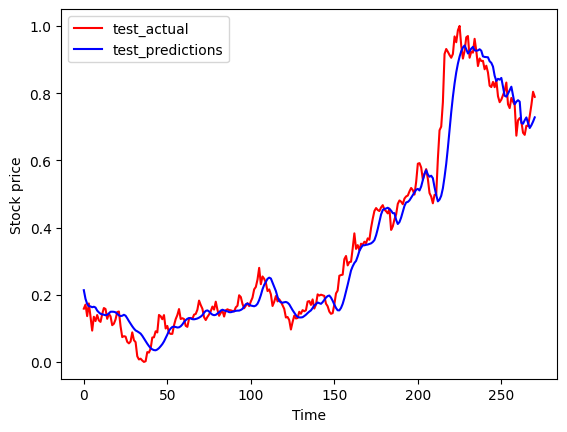

In [66]:
plt.plot(time_series_test_Y, color='r', label="test_actual")
plt.plot(test_predictions, color='b',label='test_predictions')
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.show()


## CORRELATION

In [137]:
def correlation_between_stocks(stock1, stock2, batch_size):
    """
    Calculates pearson correlation between 2 stocks

    Returns :
        List of correlation values
    """
    stock1 = stock1[['DATE', 'CLOSE']]
    stock2 = stock2[['DATE', 'CLOSE']]
    if len(stock1) >= len(stock2):
        new_index = np.where(stock1["DATE"].isin(stock2["DATE"]) == True)[0][0]
    else:
        new_index = np.where(stock2["DATE"].isin(stock1["DATE"]) == True)[0][0]

    tx_index = 1
    ty_index = new_index+1
    cors = [0,0,0]
    for i in range(3, min(len(stock1), len(stock2))):
        if(i <= batch_size):
            tx = pd.DataFrame(stock1['CLOSE'][:i])
            ty = pd.DataFrame(stock2['CLOSE'][new_index:new_index+i])
        else:
            tx = pd.DataFrame(stock1['CLOSE'][tx_index:i])
            ty = pd.DataFrame(stock2['CLOSE'][ty_index:new_index+i])
            ty_index+=1
            tx_index+=1

        tx.reset_index(inplace=True)
        ty.reset_index(inplace=True)
        tx = pd.DataFrame(tx['CLOSE'])
        ty = pd.DataFrame(ty['CLOSE'])
        cors.append(tx.corrwith(ty, axis=0, method = 'pearson')['CLOSE'])
    return cors

In [138]:
if not os.path.exists("Correlations.json"):
    correlations = {}
    for stock_name in EQUITY_DATA.keys():
        if stock_name == TARGET_STOCK:
            continue
        correlations[stock_name] = correlation_between_stocks(EQUITY_DATA[stock_name], EQUITY_DATA[TARGET_STOCK], 60)

    target_len = len(EQUITY_DATA[TARGET_STOCK])
    for stock_name in correlations.keys():
        if len(correlations[stock_name]) < target_len:
            padding = [0 for _ in range(target_len - len(correlations[stock_name]))]
            correlations[stock_name] = padding + correlations[stock_name]

    file = open("Correlations.json", 'w')
    json.dump(correlations, file, indent=4)
else:
    file = open("Correlations.json", 'r')
    correlations = json.load(file)

In [139]:
for f in correlations.keys():    
    print(f,len(correlations[f]),len(EQUITY_DATA[f]))

SUNPHARMA 5306 5306
TCS 5306 4139
WIPRO 5306 5306
DRREDDY 5306 5306
INFY 5306 5306
POWERGRID 5306 3359
CIPLA 5306 5306
COALINDIA 5306 2598
HDFCBANK 5306 5306
BPCL 5306 5306
AXISBANK 5306 5306


In [140]:
correlations_softmax = np.array(pd.DataFrame(correlations))
correlations_softmax = softmax(correlations_softmax, axis=1)
correlations_keys = list(correlations.keys())
correlations_softmax

array([[0.09090909, 0.09090909, 0.09090909, ..., 0.09090909, 0.09090909,
        0.09090909],
       [0.09090909, 0.09090909, 0.09090909, ..., 0.09090909, 0.09090909,
        0.09090909],
       [0.09090909, 0.09090909, 0.09090909, ..., 0.09090909, 0.09090909,
        0.09090909],
       ...,
       [0.07823525, 0.03954414, 0.04959554, ..., 0.14330364, 0.12805963,
        0.14673603],
       [0.07212417, 0.04140408, 0.05162425, ..., 0.14587419, 0.12517596,
        0.14631964],
       [0.06467379, 0.0426655 , 0.05171803, ..., 0.14752008, 0.12319968,
        0.15081063]])

In [141]:
print("CORRELATIONS FOR A RANDOM DAY")
for stock_name in correlations.keys():
    print(f"{stock_name} : {correlations[stock_name][3000]}")

CORRELATIONS FOR A RANDOM DAY
SUNPHARMA : -0.03256712474437007
TCS : -0.3269958958470974
WIPRO : -0.5061718877660201
DRREDDY : 0.03858737795149695
INFY : 0.2208194887410984
POWERGRID : 0.40577459534395743
CIPLA : -0.6243474818151129
COALINDIA : 0.7445137888019995
HDFCBANK : 0.8491441169539345
BPCL : 0.8029777429779758
AXISBANK : 0.9074469910195068


In [142]:
print("SOFTMAX CORRELATIONS FOR A RANDOM DAY")
counter = 1
for stock_name in correlations_keys:
    print(f"{stock_name} : {correlations_softmax[3000][counter-1]}")
    counter += 1

SOFTMAX CORRELATIONS FOR A RANDOM DAY
SUNPHARMA : 0.061389069585655626
TCS : 0.0457322175360094
WIPRO : 0.038230248067557274
DRREDDY : 0.06591633604560013
INFY : 0.07909252842767533
POWERGRID : 0.09516131646983388
CIPLA : 0.0339691052516606
COALINDIA : 0.1335282028823774
HDFCBANK : 0.14825637538350586
BPCL : 0.14156750454552466
AXISBANK : 0.1571570958045999


### MODEL CREATION

In [143]:
def get_time_series_data(data:pd.DataFrame):
    train_X = data.copy()
    train_Y = pd.DataFrame(data['ACTUAL_PRICE'].copy())
    train_X = train_X.drop(['ACTUAL_PRICE', 'DATE'], axis=1)

    scaler = MinMaxScaler()
    train_X = pd.DataFrame(scaler.fit_transform(train_X))
    train_Y = pd.DataFrame(scaler.fit_transform(train_Y))
    
    time_series_train_X = []
    time_series_train_Y = []

    for ind in range(TIME_SERIES_INTERVAL, train_X.shape[0]):
        time_series_train_X.append(train_X[ind - TIME_SERIES_INTERVAL : ind])
        time_series_train_Y.append(train_Y.iloc[ind])
        
    time_series_train_X, time_series_train_Y = np.array(time_series_train_X), np.array(time_series_train_Y)

    print(time_series_train_X.shape, time_series_train_Y.shape)
    return time_series_train_X, time_series_train_Y

In [177]:
rnn_model = Sequential()

rnn_model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (time_series_train_X.shape[1], time_series_train_X.shape[2])))
rnn_model.add(Dropout(0.2))

# regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
# regressor.add(Dropout(0.2))

rnn_model.add(LSTM(units = 120, activation = 'relu'))
rnn_model.add(Dropout(0.2))

rnn_model.add(Dense(units = 1))

In [178]:
rnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 60, 60)            15840     
                                                                 
 dropout_30 (Dropout)        (None, 60, 60)            0         
                                                                 
 lstm_31 (LSTM)              (None, 120)               86880     
                                                                 
 dropout_31 (Dropout)        (None, 120)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 121       
                                                                 
Total params: 102,841
Trainable params: 102,841
Non-trainable params: 0
_________________________________________________________________


In [179]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.MeanSquaredError()
batch_size = 256
epochs = 200

TS_CUSTOM_FEATURES = dict()

for stock_name in CUSTOM_FEATURES.keys():
    tran_X, tran_Y = get_time_series_data(CUSTOM_FEATURES[stock_name])
    data_set = tf.data.Dataset.from_tensor_slices((tran_X, tran_Y))
    data_set = data_set.batch(batch_size)
    TS_CUSTOM_FEATURES[stock_name] = data_set

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/xzaviourr/Projects/StockMarketPredictor/venv/lib/python3.10/site-packages/keras/backend.py", line 5132, in <genexpr>
    output_ta_t = tuple(  File "/home/xzaviourr/Projects/StockMarketPredictor/venv/lib/python3.10/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
(5246, 60, 5) (5246, 1)
(4079, 60, 5) (4079, 1)
(5246, 60, 5) (5246, 1)
(5246, 60, 5) (5246, 1)
(5246, 60, 5) (5246, 1)
(5246, 60, 5) (5246, 1)
(3299, 60, 5) (3299, 1)
(5246, 60, 5) (5246, 1)
(2538, 60, 5) (2538, 1)
(5246, 60, 5) (5246, 1)
(5246, 60, 5) (5246, 1)
(5246, 60, 5) (5246, 1)


In [180]:
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    file = open("train_log.txt", 'a')
    file.write("\nStart of epoch %d\n" % (epoch,))
    file.close()

    gradients = None
    value_counter = 0

    # Iterate over all the stocks
    for stock_name in TS_CUSTOM_FEATURES.keys():
        dataset = TS_CUSTOM_FEATURES[stock_name]
        total_days = len(dataset)*batch_size

        if stock_name == TARGET_STOCK:
            softmax_weight = [1 for _ in range(total_days)]
        else:
            ind = correlations_keys.index(stock_name)
            softmax_weight = correlations_softmax[ind][-total_days:]      

        # Iterate over the batches of the dataset.
        stock_loss_value = 0
        for step, (x_batch_train, y_batch_train) in enumerate(dataset):
            with tf.GradientTape() as tape:
                # FORWARD PASS
                logits = rnn_model(x_batch_train, training=True)  # Logits for this minibatch
                # Compute the loss value for this minibatch.
                loss_value = loss_fn(y_batch_train, logits)
                stock_loss_value += loss_value

                grads = tape.gradient(loss_value, rnn_model.trainable_weights)
                for lyr in range(len(grads)):
                    weight_value = (step + 1)*batch_size - 1
                    grads[lyr] = grads[lyr] * weight_value

                if gradients == None:
                    gradients = grads
                else:
                    for lyr in range(len(grads)):
                        gradients[lyr] = gradients[lyr] + grads[lyr]
                
                value_counter += 1
        print(
            f"Training loss (for {stock_name}) : {stock_loss_value / len(dataset)}"
        )
        
        file = open("train_log.txt", 'a')
        file.write(f"Training loss (for {stock_name}) : {stock_loss_value / len(dataset)}\n")
        file.close()
    
    for lyr in range(len(gradients)):
        gradients[lyr] = gradients[lyr] / value_counter
    optimizer.apply_gradients(zip(gradients, rnn_model.trainable_weights))
    rnn_model.save(f"models/epoch{epoch}.h5")


Start of epoch 0
Training loss (for SUNPHARMA) : 0.07094994932413101
Training loss (for TCS) : 0.20245815813541412
Training loss (for WIPRO) : 0.014483192004263401
Training loss (for SBIN) : 0.11407889425754547
Training loss (for DRREDDY) : 0.13443848490715027
Training loss (for INFY) : 0.02896042726933956
Training loss (for POWERGRID) : 0.26452910900115967
Training loss (for CIPLA) : 0.13393180072307587
Training loss (for COALINDIA) : 0.3008160889148712
Training loss (for HDFCBANK) : 0.1815546751022339
Training loss (for BPCL) : 0.12741482257843018
Training loss (for AXISBANK) : 0.11713331937789917

Start of epoch 1
Training loss (for SUNPHARMA) : 0.059897154569625854
Training loss (for TCS) : 0.17351134121418
Training loss (for WIPRO) : 0.011666445061564445
Training loss (for SBIN) : 0.0977390706539154
Training loss (for DRREDDY) : 0.11469485610723495
Training loss (for INFY) : 0.023480674251914024
Training loss (for POWERGRID) : 0.22794188559055328
Training loss (for CIPLA) : 0.114

In [105]:
rnn_model = keras.models.load_model("models/epoch49.h5")

In [106]:
summary = str(rnn_model.summary())
print(summary)
# inp = rnn_model.get_config()
# print(inp)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 60, 60)            15840     
                                                                 
 dropout_36 (Dropout)        (None, 60, 60)            0         
                                                                 
 lstm_37 (LSTM)              (None, 120)               86880     
                                                                 
 dropout_37 (Dropout)        (None, 120)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 121       
                                                                 
Total params: 102,841
Trainable params: 102,841
Non-trainable params: 0
_________________________________________________________________
None


9/9 [==============================] - 0s 17ms/step
     test_predictions  test_actual
0            0.330041     0.158502
1            0.306543     0.170607
2            0.285545     0.136372
3            0.267189     0.174012
4            0.251883     0.135048
..                ...          ...
266          0.774521     0.702099
267          0.765426     0.731795
268          0.757631     0.764895
269          0.750994     0.804048
270          0.746273     0.788916

[271 rows x 2 columns]
RMSE :  0.08639936655296294


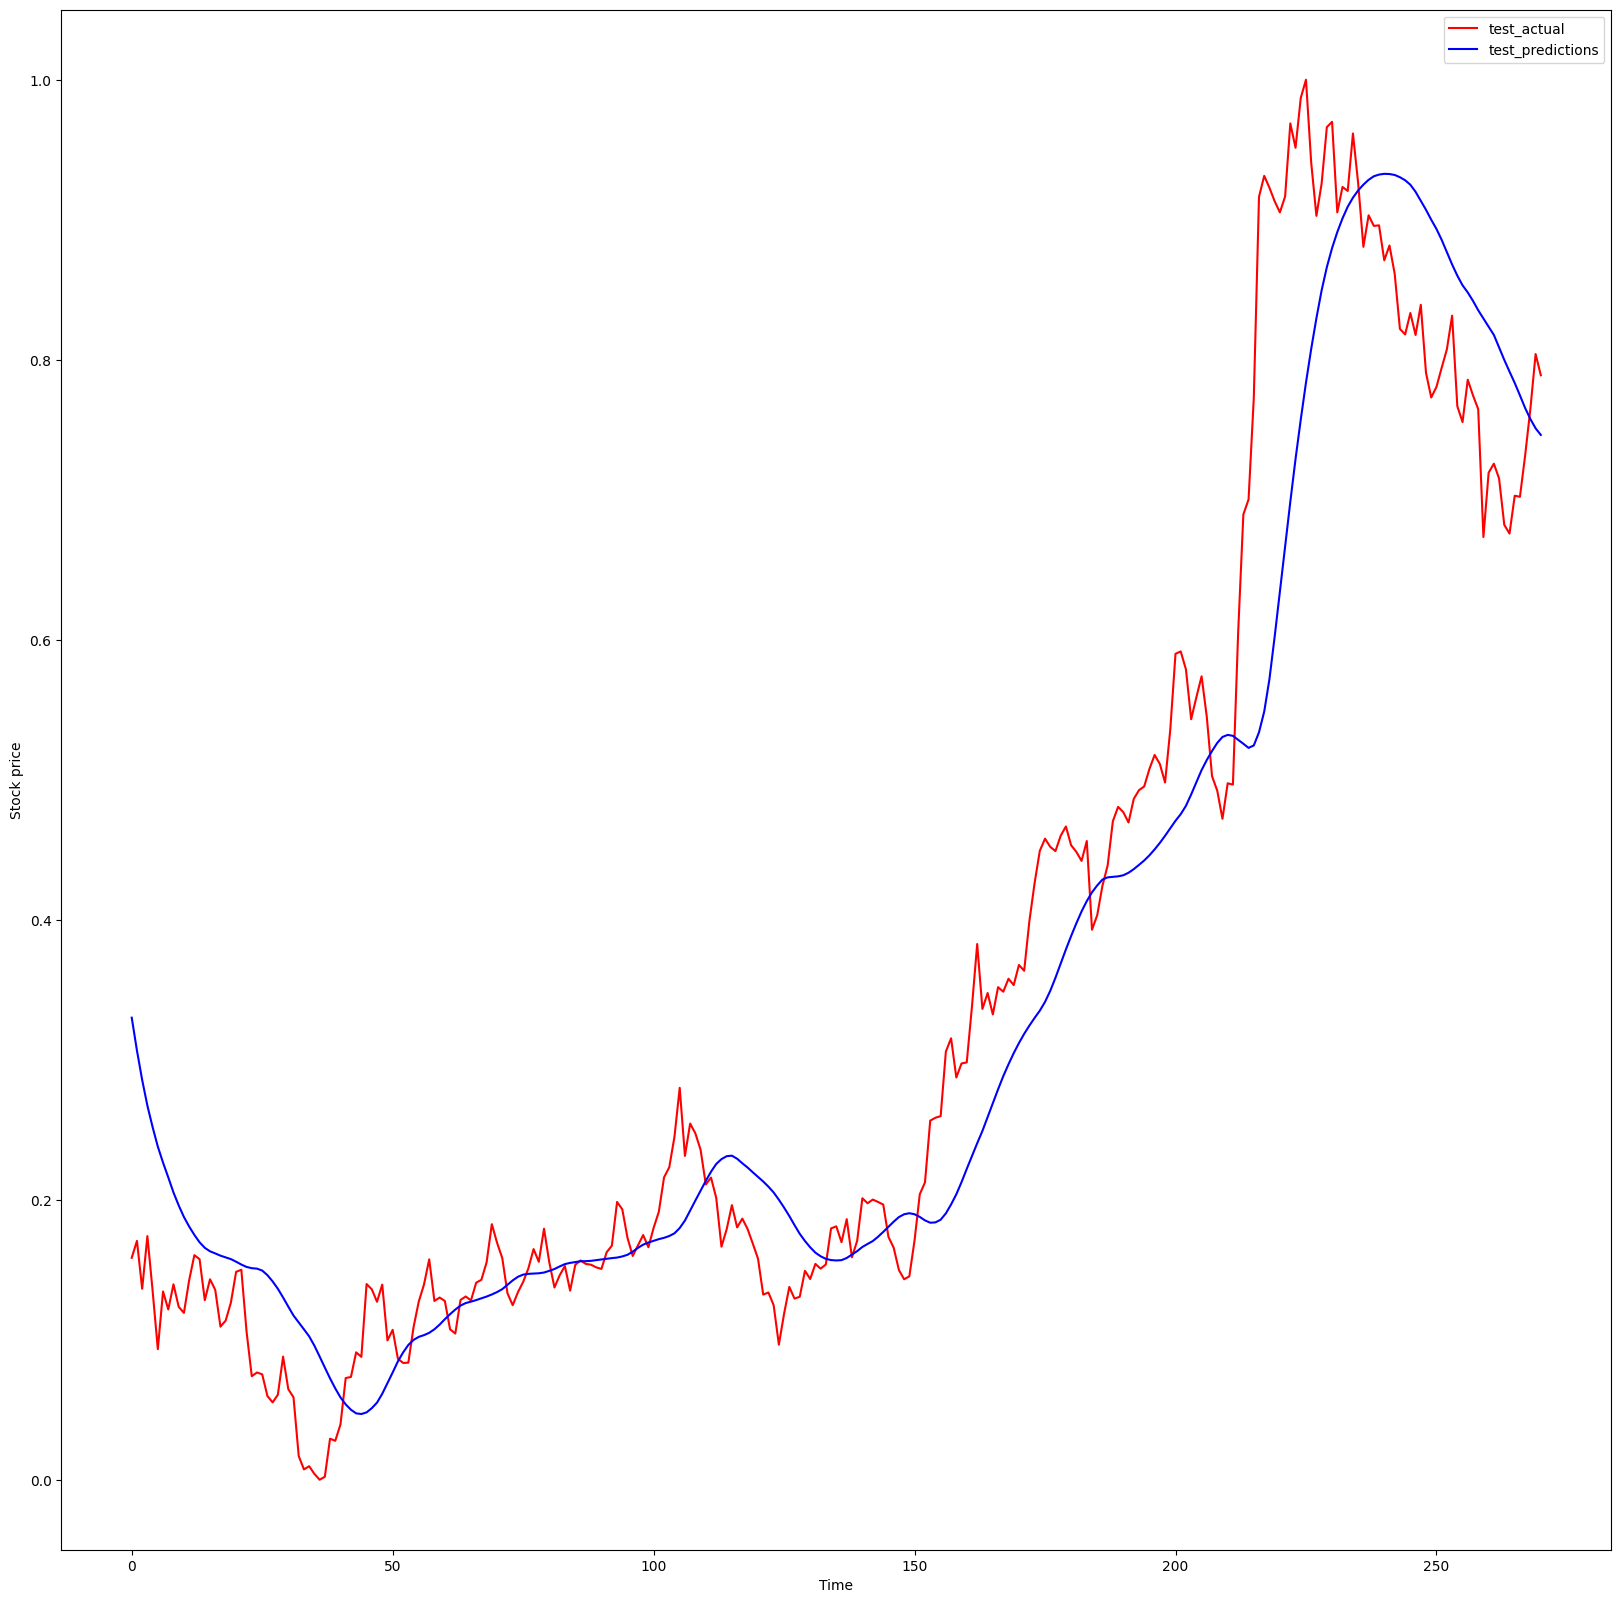

In [107]:
test_predictions = rnn_model.predict(time_series_test_X)

temp = []
for ind in range(len(test_predictions)):
    temp.append([test_predictions[ind][0], float(time_series_test_Y[ind])])
print(pd.DataFrame(temp, columns = ["test_predictions", "test_actual"]))
MSE = np.square(np.subtract(time_series_test_Y, test_predictions)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE : ", RMSE)

plt.figure(figsize=(20, 20))
plt.plot(time_series_test_Y, color='r', label="test_actual")
plt.plot(test_predictions, color='b',label='test_predictions')
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.savefig("test_loss.png")
plt.show()


152/152 [==============================] - 2s 16ms/step
      train_predictions  train_actual
0              0.033939      0.025788
1              0.034269      0.025564
2              0.034555      0.025997
3              0.034807      0.026460
4              0.035018      0.025668
...                 ...           ...
4850           0.061690      0.056742
4851           0.061796      0.056264
4852           0.061913      0.058474
4853           0.062027      0.057623
4854           0.062115      0.057429

[4855 rows x 2 columns]
RMSE :  0.03785213249684822


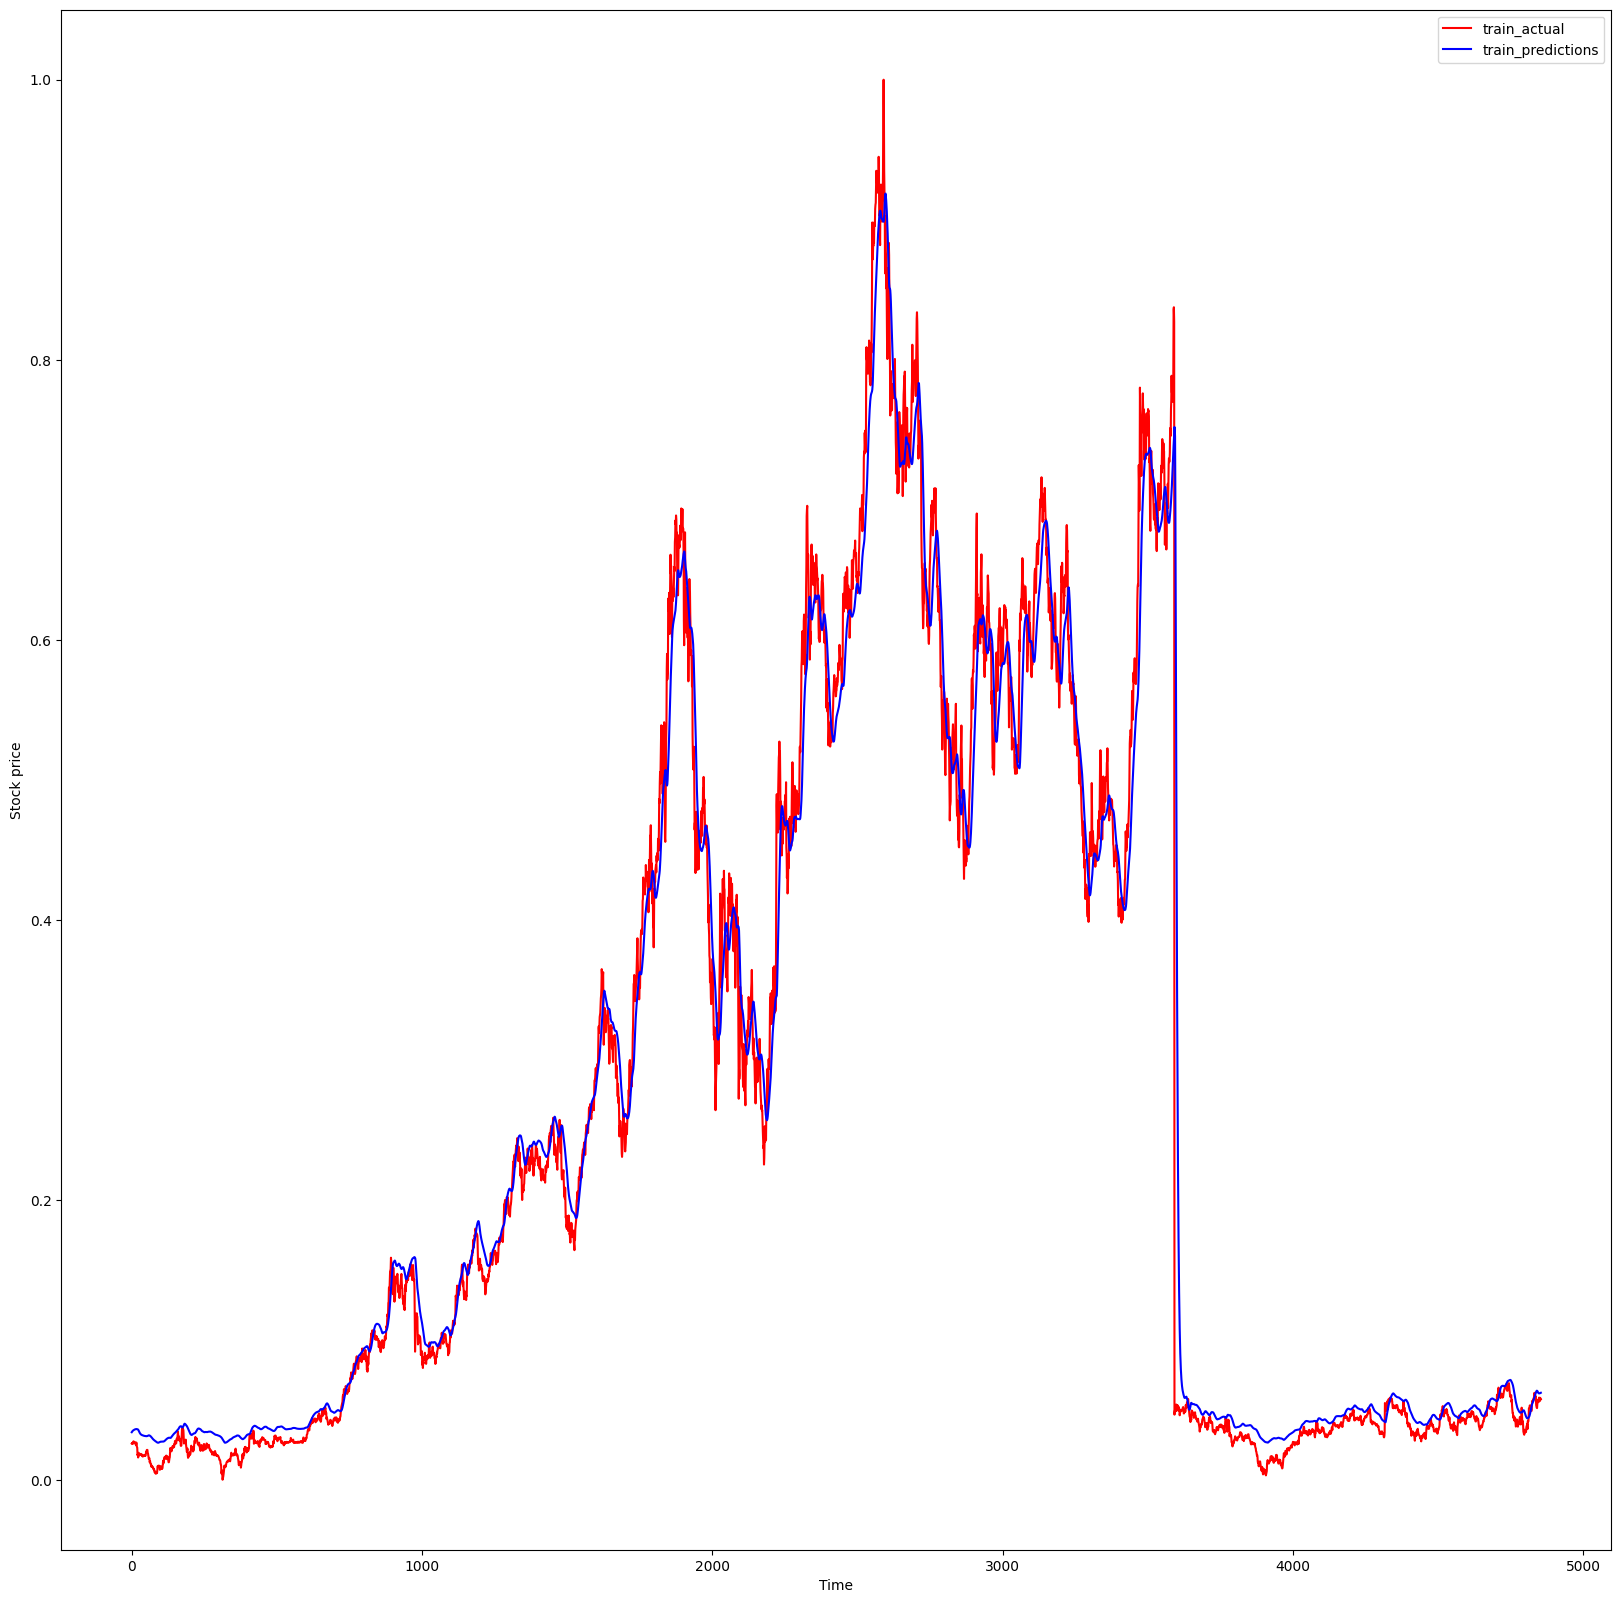

In [108]:
train_predictions = rnn_model.predict(time_series_train_X)

temp = []
for ind in range(len(train_predictions)):
    temp.append([train_predictions[ind][0], float(time_series_train_Y[ind])])
print(pd.DataFrame(temp, columns = ["train_predictions", "train_actual"]))
MSE = np.square(np.subtract(time_series_train_Y, train_predictions)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE : ", RMSE)

plt.figure(figsize=(20, 20))
plt.plot(time_series_train_Y, color='r', label="train_actual")
plt.plot(train_predictions, color='b',label='train_predictions')
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.savefig('train_loss.png')
plt.show()

### ANALYZING THE MSE FOR INDIVIDUAL STOCKS

In [144]:
import matplotlib.pyplot as plt
import pandas as pd

with open('train_log.txt') as f:
  l = []
  for lines in f:
    x = lines.split('\n\n')
    if(x!=['\n']):  
      for w in x:
        temp = w.split(': ')
        if(len(temp)==2):
          temp = temp[-1].split('\n')
          l.append(float(temp[0]))
f = []
for i in range(int(len(l)/12)):
  f.append(l[12*i:12*i+12])
print(f[0])

labels = ["SUNPHARMA", "TCS", "WIPRO", "SBIN", "DRREDDY", "INFY", "POWERGRID", "CIPLA", "COALINDIA", "HDFCBANK", "BPCL", "AXISBANK"]

[0.0738048106431961, 0.21094246208667755, 0.01487253699451685, 0.11871012300252914, 0.13994131982326508, 0.029870033264160156, 0.2753264605998993, 0.13897566497325897, 0.31296980381011963, 0.18871009349822998, 0.13195423781871796, 0.12143980711698532]


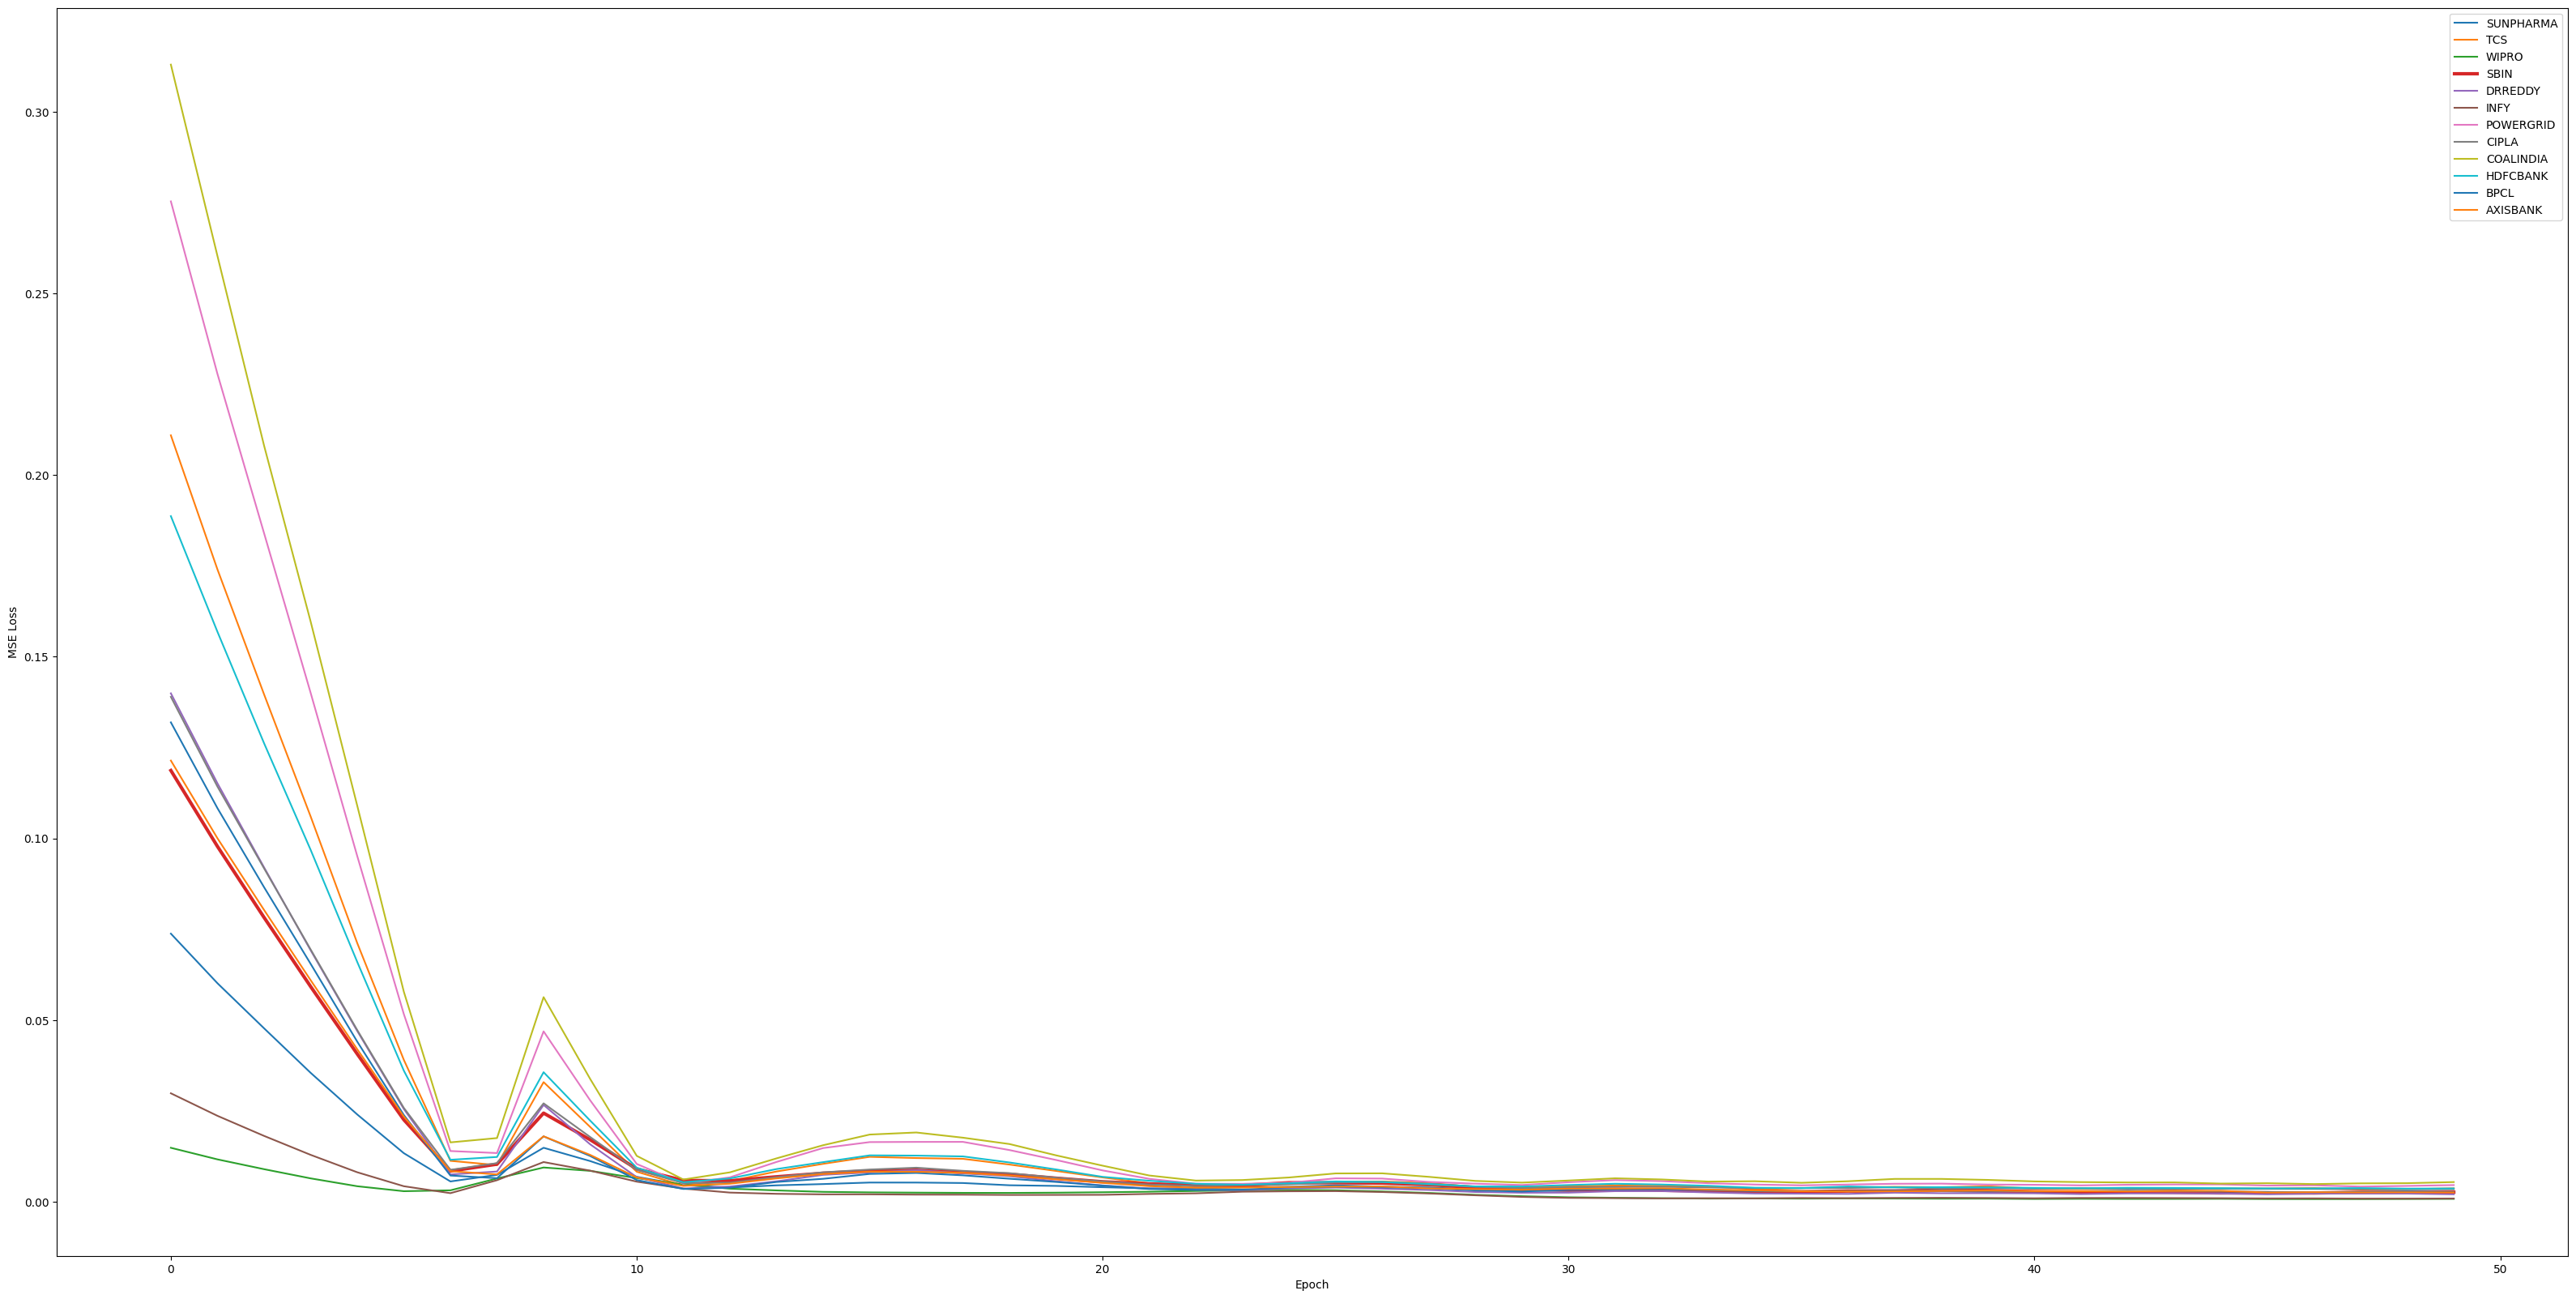

In [145]:
figure = plt.figure(figsize=(40,20))
data = pd.DataFrame(f)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
for i in range(12):
    if labels[i] == "SBIN":
        plt.plot(data[i][:50], label=labels[i], linewidth=3)      
    else:
        plt.plot(data[i][:50], label=labels[i])
plt.legend(loc=0)

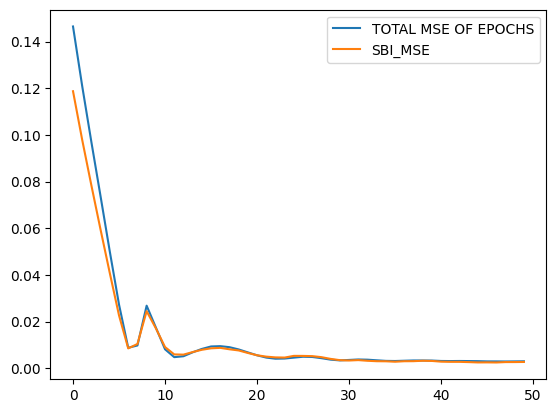

In [146]:
total_mse = data.sum(axis=1)/12
sbi_mse = data[3]
plt.plot(total_mse[:50], label="TOTAL MSE OF EPOCHS")
plt.plot(sbi_mse[:50], label = "SBI_MSE")
plt.legend(loc=0)

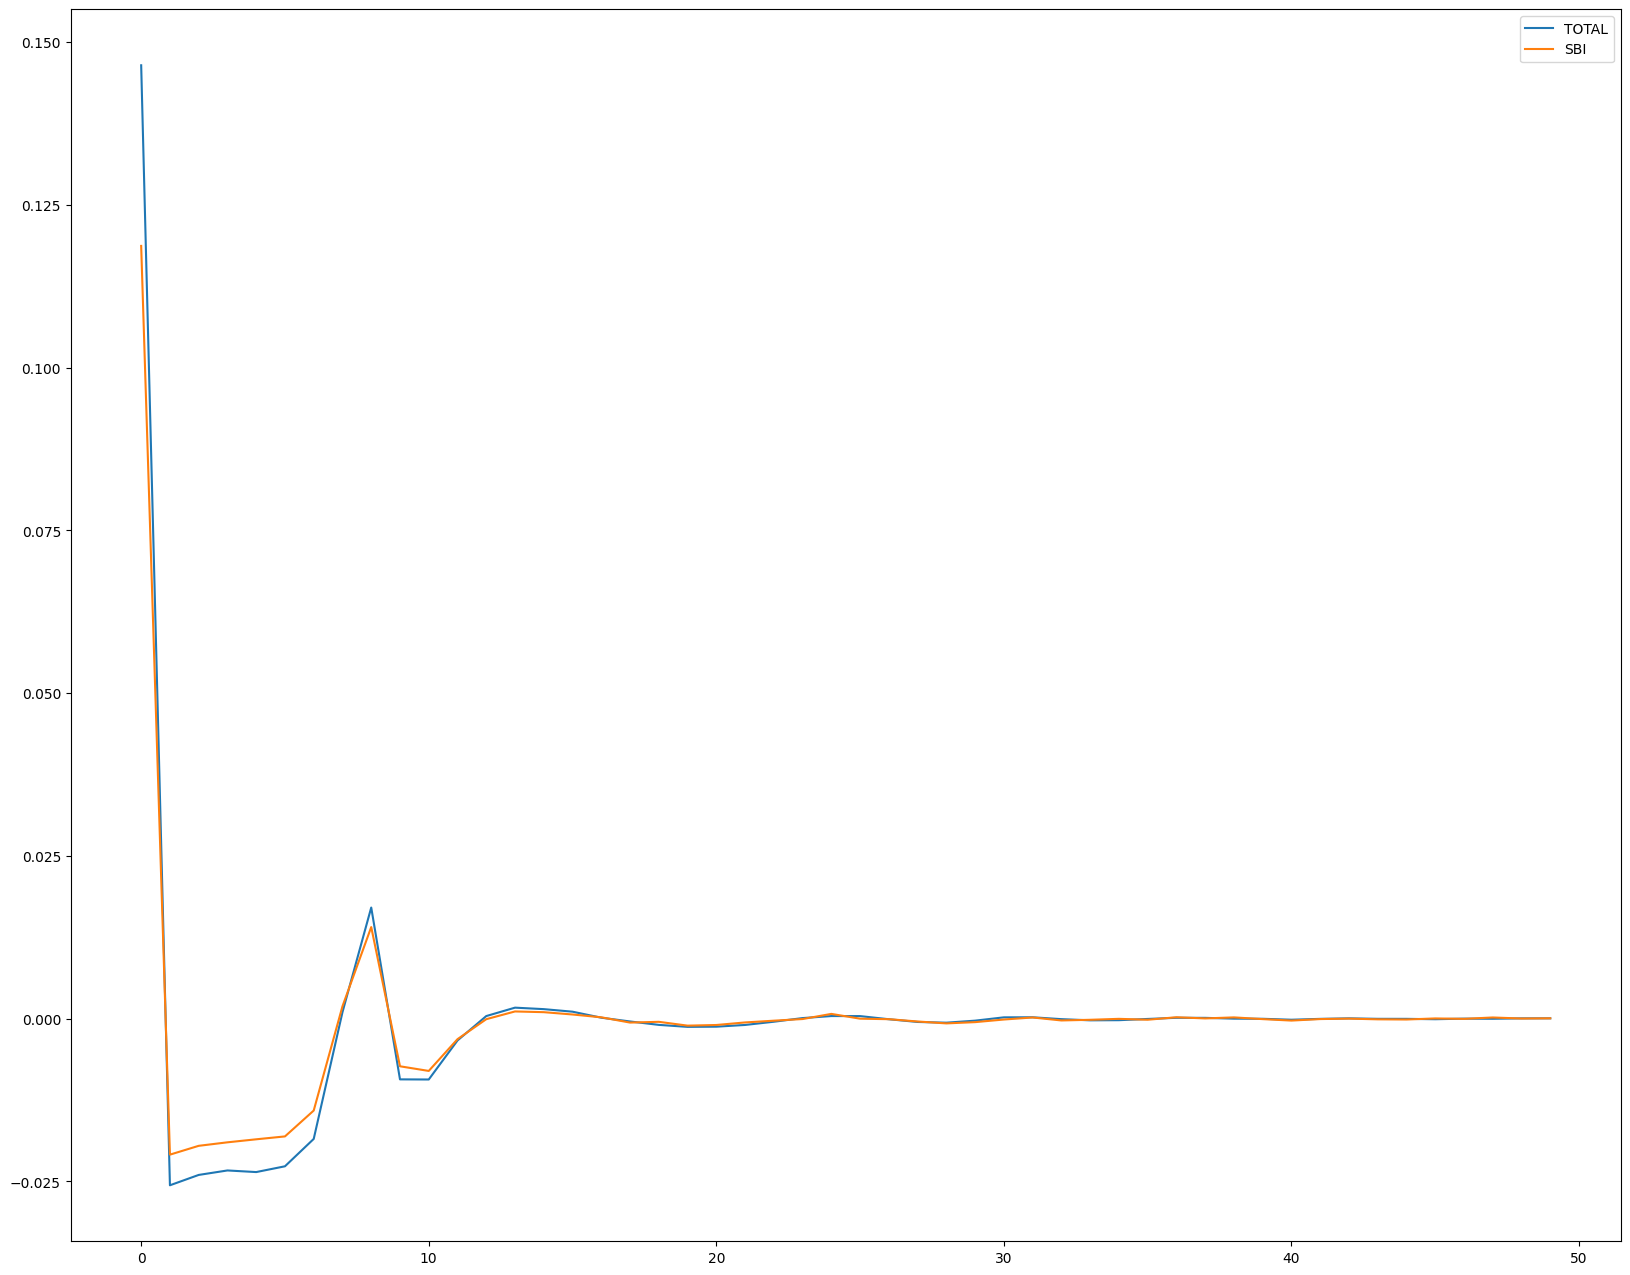

In [147]:
for i in reversed(range(1,len(data))):
    total_mse.iloc[i] = total_mse.iloc[i]-total_mse.iloc[i-1]
    sbi_mse.iloc[i] = sbi_mse.iloc[i]-sbi_mse.iloc[i-1]
plt.figure(figsize=(20,16))
plt.plot(total_mse, label="TOTAL")
plt.plot(sbi_mse, label = "SBI")
plt.legend(loc=0)

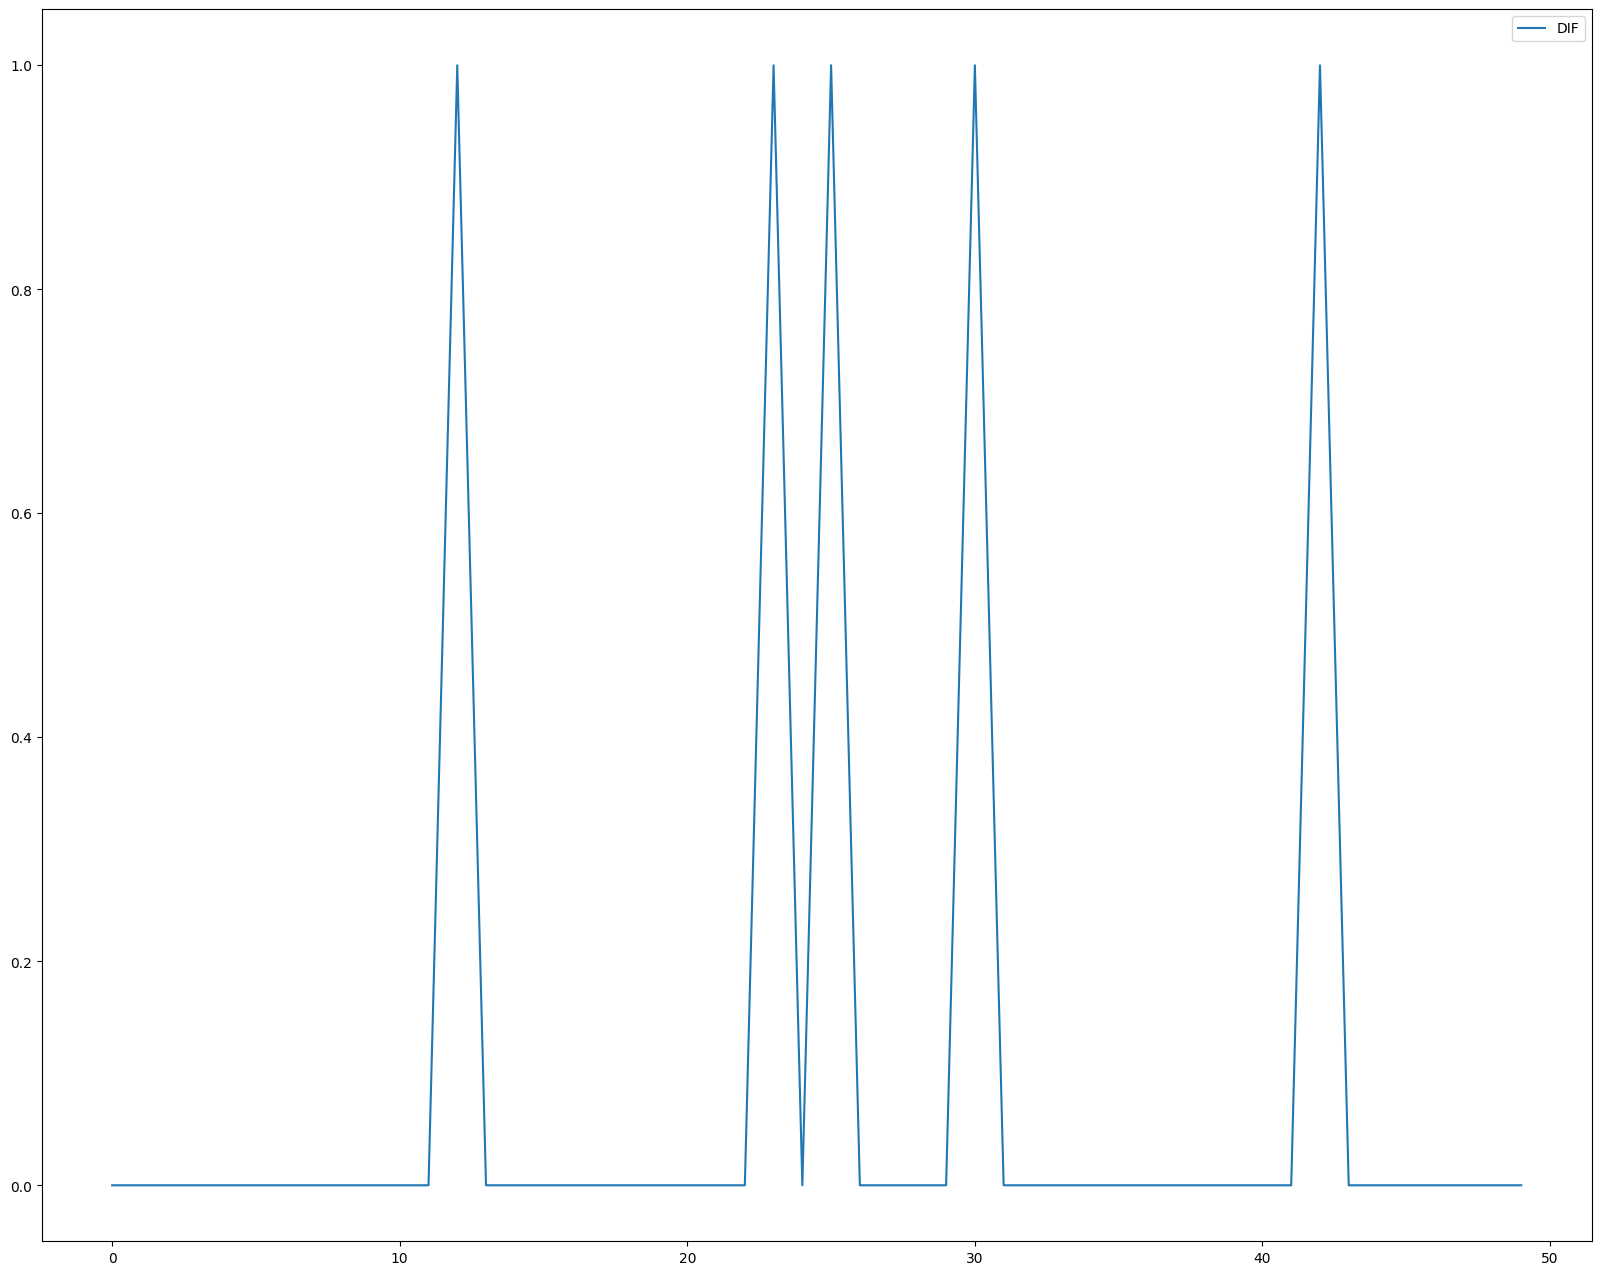

In [149]:
total_mse = list(total_mse)
sbi_mse = list(sbi_mse)
total_mse = [1 if x > 0 else -1 for x in total_mse]
sbi_mse = [1 if x > 0 else -1 for x in sbi_mse]
dif = []
dif = [1 if sbi_mse[i]<total_mse[i] else 0 for i in range(len(total_mse)) ]

plt.figure(figsize=(20,16))
plt.plot(dif, label="DIF")
# plt.plot(sbi_mse, label = "SBI")
plt.legend(loc=0)